<a href="https://colab.research.google.com/github/Anastasios-K/Classification/blob/master/WineQualClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random as rng
import numpy as np
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sb

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# --> from pathlib import Path
path = Path('/content/drive/My Drive/DS Projects/Classification/Wine Quality')
directories = list(path.iterdir())
# ------> Look for further selection from the directories

# Add extra datasets into the parent directory

In [0]:
dimensions = 12
attributes = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
              'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
              'pH', 'sulphates', 'alcohol', 'quality']

# This is to create a dict with all dataframes
# Multiple files from cloud compose the final dataframe
# The dimensionality of the data and the attributes' names are required
# The list of the datasets is created before

def DF_dict_generator(list_of_datasets, dimensionality, attributes):
  wine_dict = {}
  for i, item in enumerate(list_of_datasets):
    wine_dict["df{0}".format(i+1)]=pd.read_csv(item, delimiter=';', skip_blank_lines=False,skipinitialspace=True)
    if len(wine_dict["df{0}".format(i+1)].columns) != dimensionality:
      wine_dict["df{0}".format(i+1)]=pd.read_csv(item, delimiter=';', skip_blank_lines=False,skipinitialspace=True, skiprows=[0], names=attributes)
    else:
      pass
    wine_dict["df{0}".format(i+1)]['wine type'] = pd.Series(i+1, index=wine_dict["df{0}".format(i+1)].index)
  df = pd.concat(wine_dict, ignore_index=True)
  return(df)

In [0]:
#### ---------> use of the above function "DF_dict_generator"
df = DF_dict_generator(directories,12,attributes)

In [0]:
# It is --- N O T --- necesary
# Use it to test the below quality function
# This is to add some missing values to the data (currently 20%)
# Change the amount of missing values by changing the "Error_PerCent" variable
# The below libraries are required

# --> import random as rng
# --> import numpy as np

def Null_test(df):
  Error_PerCent = 0.2
  rng.seed()
  num_of_NAN = np.round(len(df)*len(df.columns)*Error_PerCent, decimals=0)
  for x in range(int(num_of_NAN)):
      df.iloc[rng.randint(0,len(df)-1),rng.randint(0,len(df.columns)-1)]=np.nan
  return(df)
if __name__ == "__main__":
    pass


In [0]:
#### ---------> use of the above function "Null_test"
df = Null_test(df)

In [0]:
# This is to do the following:
# 1. Detecting missing values
# 2. Removing an attribute if it includes more than 20% of missing values
# 3. Filling up the NaN values using the average of the last and next valid values

# Change the "tolerance" variable to change the when a column is removed
# The numpy library is required
# The Quality list shows the percenatge of valid values per attribute before the filling function

# --> import numpy as np

def Drop_Fill(df):
  Quality=[]
  tollerance = 0.2
  for column in df:
    quality = df[column].isnull().value_counts()
    a = np.round(quality.iloc[0]/len(df), decimals=3)
    Quality.append(a)
    if a < 1 - tollerance:
      df = df.drop([column], axis=1)
    else:
      pass
  front_fill = df.ffill()
  back_fill = df.bfill()
  front_fill = front_fill.bfill() # The reverse method covers the case of NaN values on the first row
  back_fill = back_fill.ffill()   # The same here for NaN values at the last row
  df = (front_fill+back_fill)/2
  return(df, Quality)


In [0]:
#### ---------> use of the above function "Drop_Fill"
df, Quality =Drop_Fill(df)

In [0]:
# The label of product_type was also added above
# Currently, only the quality label is used for the calssification
# 20% of the data is used for testing

Depend_quality = df.iloc[0:,11]
Depend_type = df.iloc[0:,12]
Predictors = df.iloc[0:,:11]

X_train, X_test, Y_train, Y_test = split(Predictors, Depend_quality, test_size=0.2, random_state=7, shuffle=True)
df = X_train

In [0]:
# This function returns subplots with a number of histograms. The popular wine dataset is currently used for testing. However, the fucntion can work with ant dataset without modifications
# The optimal number of bins is calculated
# The distribution density line is also fitted
# The Anderson-Darling normality test is used to assist with the distribution evaluation
# One of the most powreful techniques based on the research
# On the top-right corner of each graph the difference between the AD t-test and the critical value is depicted
# Distributions with AD >= 0 are ONLY considered as normal for a significance level of 0.05

# The below libraries are required
# --> import pandas as pd
# --> import numpy as np
# --> from scipy import stats
# --> import matplotlib.pyplot as plt
# --> import seaborn as sb

def Distribution(df, columns_num):
  length = len(df.columns)
  lines = length%columns_num + length//columns_num
  figure = plt.figure(
      figsize= (2.4*columns_num,3.3*lines),
      facecolor='w'
      )
  plt.subplots_adjust(
      left= 0.1, 
      right= 1, 
      wspace= 0.1, 
      hspace= 0.15
      )
  sb.set_style("dark")
  for i, column in enumerate(df):
    #Shapiro_Wilk = np.around((np.array(stats.shapiro(df[column]))), 3)   #---> Comment out to use Shapiro Wilk test (BUT comment in the next line to avoid confusion)
    t_stat, crit_vals, _ = stats.anderson(df[column], dist='norm')
    ax = plt.subplot(lines,columns_num, i+1)
    hist, bins = np.histogram(df[column], bins= 'auto', density= True)
    sb.distplot(np.array(df[column]), bins = bins, hist= True, kde=True, color= 'b')
    ax.set_title(df.columns[i], weight = 'bold', size = 10)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    plt.text(
      bins[-1],
      hist.max(),
      #'SW' + ": " + str(Shapiro_Wilk[1]),   #---> Comment out to use Shapiro Wilk test (BUT comment in the next line to avoid confusion)
      'AD' + ': ' + str(np.around((crit_vals[2]-t_stat), 3)),
      fontsize = 8,
      fontweight = 'bold',
      color = 'r',
      ha = 'right',
      va = 'top'
      )
  plt.show()
  return figure

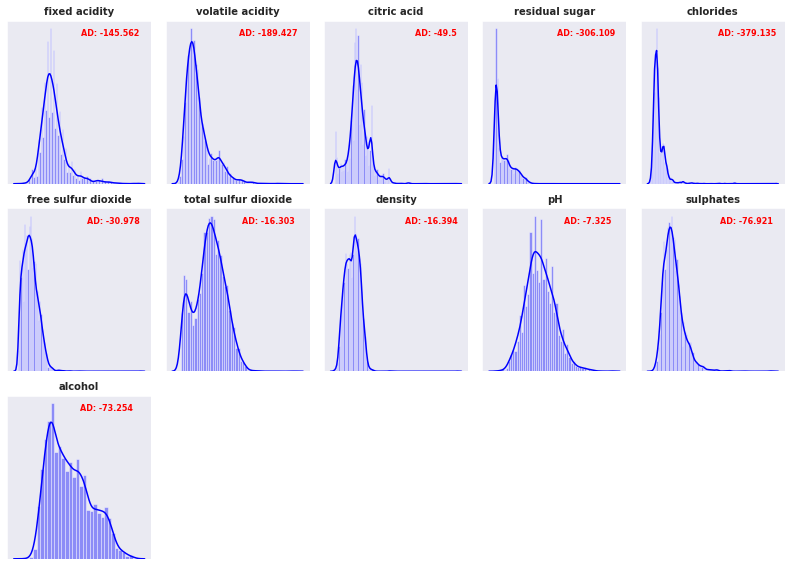

In [85]:
#### ---------> use of the above function "Distribution"
Probability_Distrib = Distribution(X_train, 5)

In [0]:
def Outlier_Values(df, columns_num):
  length = len(df.columns)
  lines = length%columns_num + length//columns_num
  figure = plt.figure(
      figsize= (1.5*columns_num,4*lines),
      facecolor='w'
      )
  plt.subplots_adjust(
      left= 0.1, 
      right= 1, 
      wspace= 0.1, 
      hspace= 0.15
      )
  sb.set_style("dark")
  for i, column in enumerate(df):
    ax = plt.subplot(lines,columns_num, i+1)
    df.boxplot(column = column,
                    grid = False, 
                    whis = 1.5,
                    autorange = False,
                    showmeans = False,
                    flierprops = dict(markerfacecolor='r', marker='o'),
                    )
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.set_title(df.columns[i], weight = 'bold', size = 10)
  plt.show()
  return figure

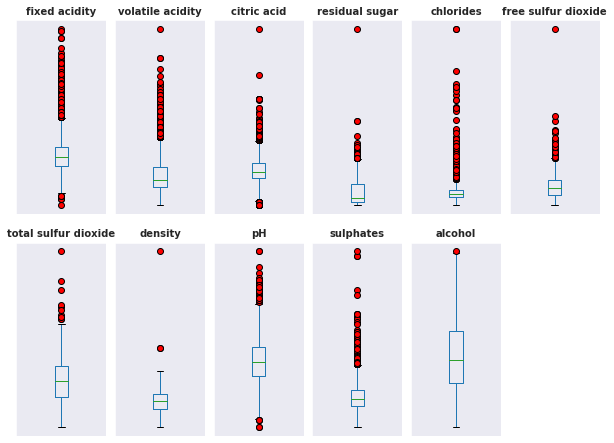

In [108]:
Outlier_analysis = Outlier_Values(df, 6)